In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
%matplotlib inline

In [3]:
today = pd.to_datetime(date.today())

In [4]:
df_all = pd.read_csv('case-hosp-death.csv')
probable_df = pd.read_csv('probable-confirmed-dod.csv')

df_all['DATE_OF_INTEREST'] = pd.to_datetime(df_all['DATE_OF_INTEREST'])
probable_df['DATE_OF_INTEREST'] = pd.to_datetime(probable_df['DATE_OF_INTEREST'])

In [5]:
# merge probably and confirmed deaths
df_all = pd.merge(df_all, probable_df, on ='DATE_OF_INTEREST', how = 'left')

'''
confirm that DEATH_COUNT in 'case-hosp-death.csv' 
is equivalent to CONFIRMED_DEATHS in 'probable-confirmed-dod.csv'
(should display empty dataframe to confirm)
'''
mask = (df_all.DEATH_COUNT != df_all.CONFIRMED_DEATHS) \
            & (df_all.CONFIRMED_DEATHS.isnull() == False)
df_all[mask]

,DATE_OF_INTEREST,NEW_COVID_CASE_COUNT,HOSPITALIZED_CASE_COUNT,DEATH_COUNT,CONFIRMED_DEATHS,PROBABLE_DEATHS


In [6]:
# construct combined deaths attribute
df_all['deaths'] = df_all['CONFIRMED_DEATHS']+df_all['PROBABLE_DEATHS']

In [7]:
# get totals to date
total_cases = int(df_all['NEW_COVID_CASE_COUNT'].sum())
total_hosp = int(df_all['HOSPITALIZED_CASE_COUNT'].sum())
total_deaths = int(df_all['deaths'].sum())

In [8]:
def run_dash_with_x_newest_days_removed(x):
    
    df=df_all.copy()
    
    # remove days within x days of today (because of data delay)
    df = df.loc[(today - df['DATE_OF_INTEREST'])>pd.Timedelta(days=x)]
    
    daysoftheweek = np.arange(7)

    firstdate = df['DATE_OF_INTEREST'].min()
    firstday = firstdate.dayofweek
    lastday = daysoftheweek[np.argwhere(daysoftheweek==firstday)[0,0]-1]
    
    # create list of mondays
    mons = df.loc[df['DATE_OF_INTEREST'].dt.dayofweek==0]['DATE_OF_INTEREST']\
            .dt.strftime('%m/%d').values

    # create list of firstday's
    firsts = df.loc[df['DATE_OF_INTEREST'].dt.dayofweek==firstday]['DATE_OF_INTEREST']\
            .dt.strftime('%m/%d').values

    # create list of days before first day
    lasts = df.loc[df['DATE_OF_INTEREST'].dt.dayofweek==lastday]['DATE_OF_INTEREST']\
            .dt.strftime('%m/%d').values

    first_last = []
    for i, sun in enumerate(lasts):
        first_last.append(firsts[i]+' - '+sun)

    #create weeks beginning on 1st day
    df['week'] = np.floor((df['DATE_OF_INTEREST'] - firstdate).dt.days/7)
    weekly_df = df.groupby('week').agg({'NEW_COVID_CASE_COUNT':sum, 
                                        'HOSPITALIZED_CASE_COUNT':sum, 
                                        'deaths':sum})
    
    #remove weeks with less than 7 days of data
    if len(firsts)>len(lasts):
        weekly_df=weekly_df.iloc[:-1]
    
    df['date'] = df['DATE_OF_INTEREST'].dt.strftime('%m/%d')
    
    
    
    #plot dash
    fig, ax = plt.subplots(3, 3, figsize=(24,15), dpi=100)

    ax[0][0].plot(df['date'], df['NEW_COVID_CASE_COUNT'], lw=2.5, color='#334235')
    ax[0][0].set_title('Daily COVID Cases (Log Scale)', fontsize=18)
    ax[0][0].set_yscale('log')
    ax[0][0].legend(['Total NYC COVID Cases: {:,}'.format(total_cases)], 
                    loc='lower right', framealpha=1, fontsize=14)

    ax[1][0].plot(df['date'], df['NEW_COVID_CASE_COUNT'], lw=2.5, color='#334235')
    ax[1][0].set_title('Daily COVID Cases', fontsize=18)

    ax[2][0].bar(weekly_df.index, weekly_df['NEW_COVID_CASE_COUNT'], color='#334235')
    ax[2][0].set_title('Weekly COVID Cases', fontsize=18)


    ax[0][1].plot(df['date'], df['HOSPITALIZED_CASE_COUNT'], lw=2.5, color='steelblue')
    ax[0][1].set_title('Daily Hospitalizations (Log Scale)', fontsize=18)
    ax[0][1].set_yscale('log')
    ax[0][1].legend(['Total NYC COVID Hospitalizations: {:,}'.format(total_hosp)], 
                    loc='lower right', framealpha=1, fontsize=14)

    ax[1][1].plot(df['date'], df['HOSPITALIZED_CASE_COUNT'], lw=2.5, color='steelblue')
    ax[1][1].set_title('Daily Hospitalizations', fontsize=18)

    ax[2][1].bar(weekly_df.index, weekly_df['HOSPITALIZED_CASE_COUNT'], color='steelblue')
    ax[2][1].set_title('Weekly Hospitalizations', fontsize=18)



    ax[0][2].plot(df['date'], df['deaths'], lw=2.5, color='#752822')
    ax[0][2].set_title('Daily Deaths (Log Scale)', fontsize=18)
    ax[0][2].set_yscale('log')
    ax[0][2].legend(['Total NYC COVID Death Count: {:,}'.format(total_deaths)], 
                    loc='lower right', framealpha=1, fontsize=14)

    ax[1][2].plot(df['date'], df['deaths'], lw=2.5, color='#752822')
    ax[1][2].set_title('Daily Deaths', fontsize=18)

    ax[2][2].bar(weekly_df.index, weekly_df['deaths'], color='#752822')
    ax[2][2].set_title('Weekly Deaths', fontsize=18)

    for i in range(3):
        for j in range(3):
            ax[i][j].set_axisbelow(True)
            ax[i][j].spines['right'].set_visible(False)
            ax[i][j].spines['top'].set_visible(False)
            ax[i][j].tick_params(axis='y', labelsize=12)
            if i<2:
                ax[i][j].grid(which='major', alpha=0.5)
                if j<2:
                    ax[i][j].xaxis.set_ticks(mons)
                    ax[i][j].set_xticklabels(labels = mons, fontsize=12)
                else:
                    ax[i][j].xaxis.set_ticks(mons[1:])
                    ax[i][j].set_xticklabels(labels = mons[1:], fontsize=12)
                
            else:
                ax[i][j].set_xticklabels(labels = ['']+first_last, 
                                         rotation=330, ha='left', fontsize=12)
                ax[i][j].grid(which='major', axis='y', alpha=0.5)

    plt.subplots_adjust(hspace=.3)          
    plt.show()
    
    return df

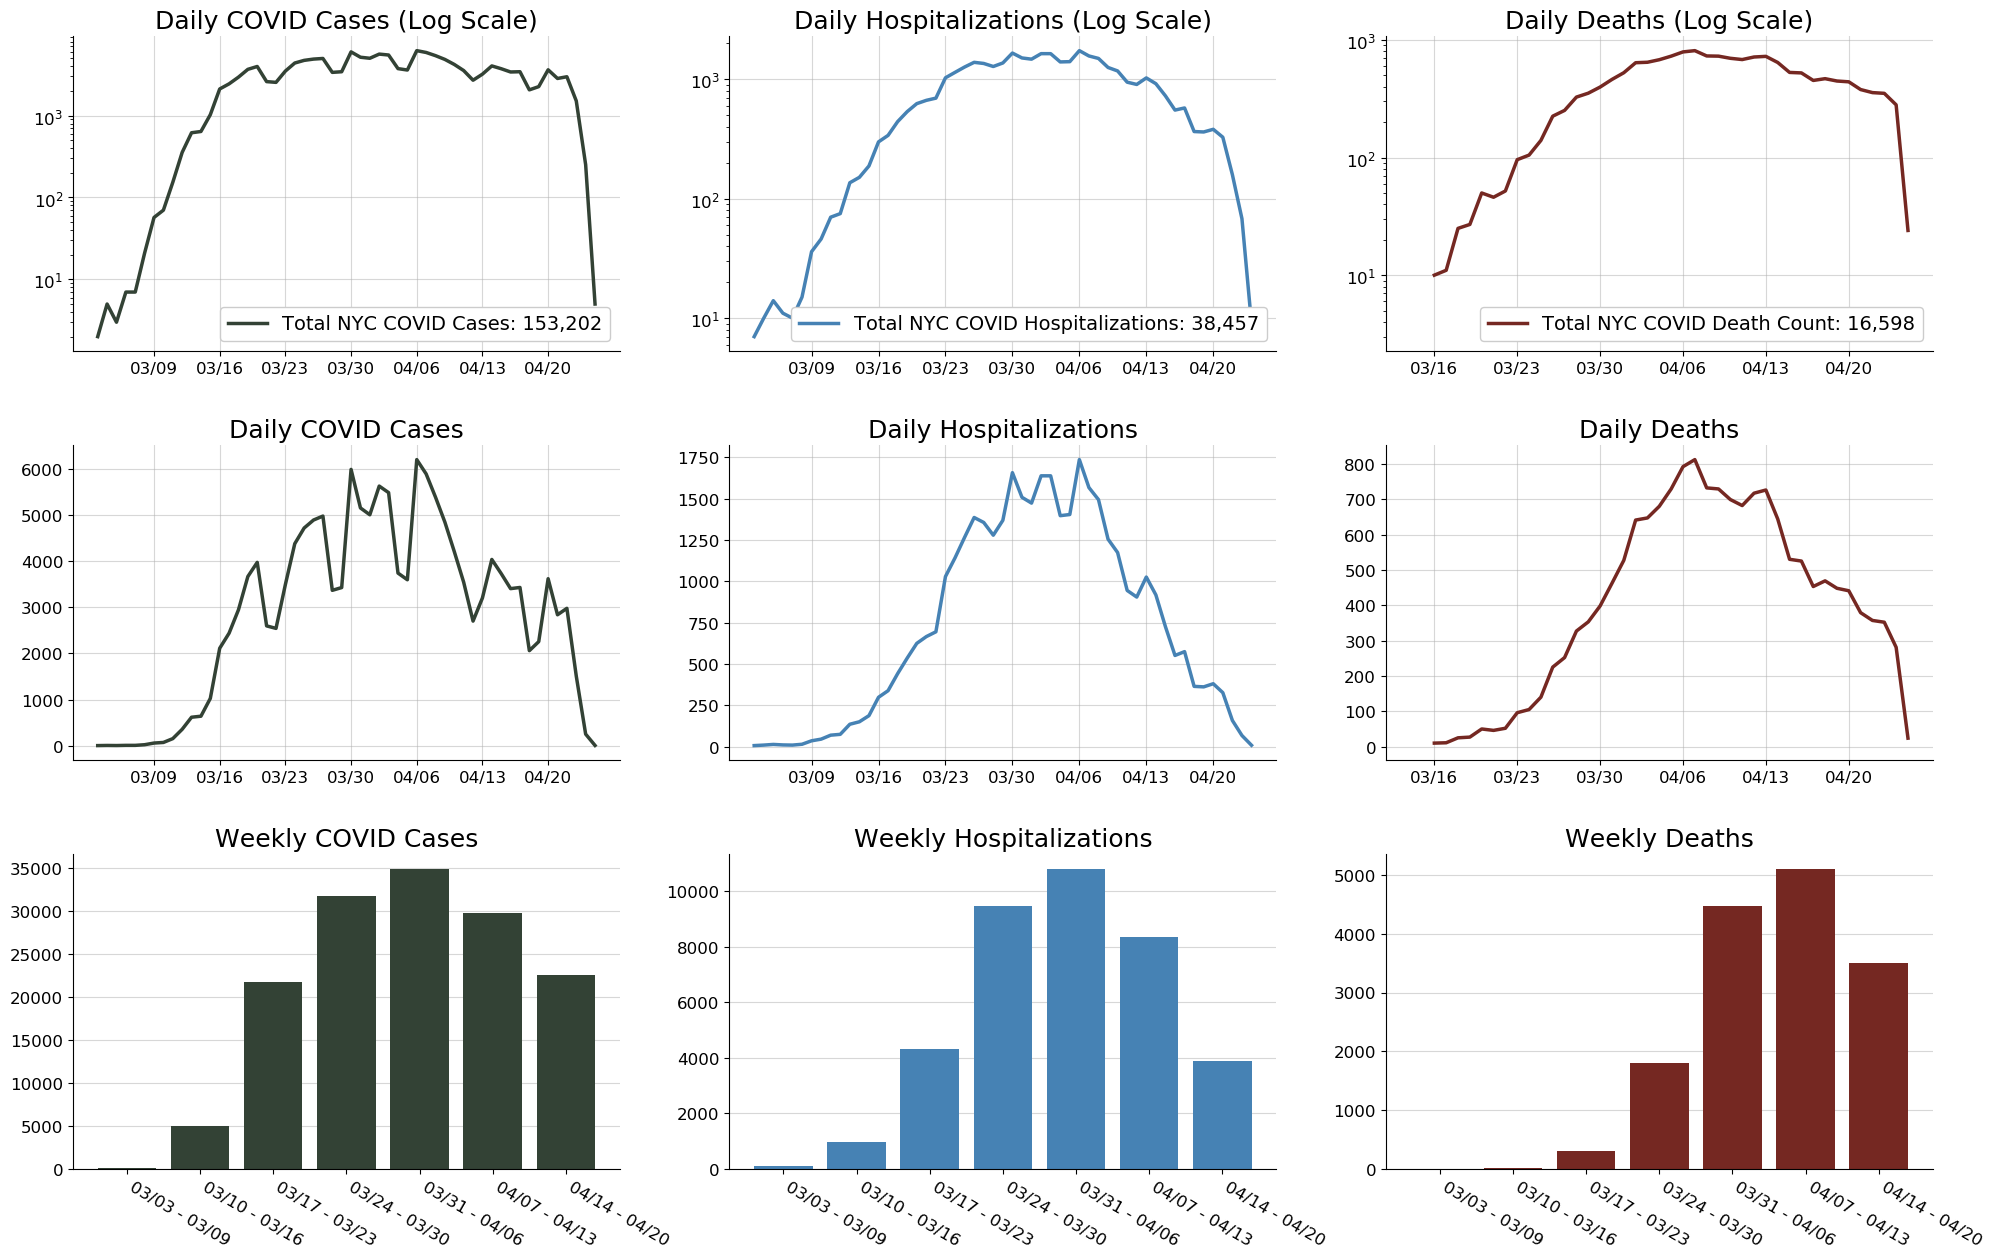

In [9]:
df_0 = run_dash_with_x_newest_days_removed(0)

## Investigating Data Reporting Delay

In [10]:
# load all available data uploads
apr26 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/da609d813e5a53dd8402ad018bc2a2d1ea7e3170/case-hosp-death.csv')
apr25 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/4bc53684bcae8ecaede11197d5f01c2d4c5f956a/case-hosp-death.csv')
apr24 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/8f4cd591c65b11c23bc3ebae25f523df5da6ceb6/case-hosp-death.csv')
apr23 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/93c29d8395f89d5d0eff39e1a9dcba69c820b33f/case-hosp-death.csv')
apr22 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/9147df02c9f9c8eab00719ffeec242088a666203/case-hosp-death.csv')
apr21 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/bbbb0f31f7a6f62b64012e8c0c5cb2d3495e6670/case-hosp-death.csv')
apr20 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/0a74f0850087758da3579886ae8b7365e182ed9e/case-hosp-death.csv')
apr19 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/498c34f8534bc865b15dd09e9b560bd457ef5b9b/case-hosp-death.csv')
apr18 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/d3a8994716870cfdbd6cc2fb356c31588446fc25/case-hosp-death.csv')
apr17 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/21916256325a11aae77bbe69029085f43592f2d1/case-hosp-death.csv')
apr16 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/86e9f032ba7fe1a6c61591cfc2413f23b7aa387b/case-hosp-death.csv')
apr15 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/165e694647d8319d7dc5cec6abc7d70cfc03c1ec/case-hosp-death.csv')
apr14 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/8e4627dd2f00d1de53355b01c8a9476d1c381b70/case-hosp-death.csv')
apr13 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/aa9a8facdf299b83ae97458dc9c55452b9ec1f53/case-hosp-death.csv')
apr12 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/d34e6aab1e0dd0e0125e74519489e7893d33c9dd/case-hosp-death.csv')
apr11 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/8542fbf18049d804eb8de7594123c13e533d1a42/case-hosp-death.csv')
apr10 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/3fdd59a195bff5c4473a2086093ed656702d6569/case-hosp-death.csv')
apr09 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/e1f1d9a63fac772e26a45220d3c8199a75938656/case-hosp-death.csv')
apr08 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/e19db289166f73282d39dfcef0d47a324d654c07/case-hosp-death.csv')
apr07 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/70904c376468567e3a2b922cc3ad1b8b854ed682/case-hosp-death.csv')
apr06 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/8cb25d611800b21a703770669606a72daa54e385/case-hosp-death.csv')
apr05 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/98a7fd1c5eccdae11d604dd98b2c4a2eafef059b/case-hosp-death.csv')
apr04 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/0ae531d56696b7dfa01d1d1ad6286d7ae03350c7/case-hosp-death.csv')
apr03 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/24fab60efbf4c22ca3e7dcc1c97427e34ddaca54/case-hosp-death.csv')
apr02 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/8562fab90b05605ef6293d60a9f2251937e5f5d7/case-hosp-death.csv')
apr01 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/dd2010c7a0757e0094b72edc7eac6d552aa00207/case-hosp-death.csv')
mar31 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/6f51a1fcca8ca44263aa7fe68de7172f9f8d9464/case-hosp-death.csv')
mar30 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/8460dd7bfdb7b74cf330dc4f260b0e7f6a5e2bb0/case-hosp-death.csv')
mar27 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/6c3565c007486fc76fe26ae66ecc7a741435292d/case-hosp-death.csv')
mar26 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/70ca08274f059df8ecf84756d1586faba149b0da/case-hosp-death.csv')

In [11]:
df_list = [mar26, mar27, mar30, mar31, 
           apr01, apr02, apr03, apr04, apr05, apr06, apr07, 
           apr08, apr09, apr10, apr11, apr12, apr13, apr14, 
           apr15, apr16, apr17, apr18, apr19, apr20, apr21, 
           apr22, apr23, apr24, apr25, apr26]

df_dates1 = pd.date_range(start='3/26/2020', end='3/27/2020')
df_dates2 = pd.date_range(start='3/30/2020', end='4/26/2020')
df_dates = df_dates1.append(df_dates2)

# create upload_date attribute
for i, df in enumerate(df_list):
    df['upload_date'] = df_dates[i]

# concatenate all data uploads into single dataframe
xtime = pd.concat(df_list, axis=0, sort=False)

In [12]:
# Fix data header error

xtime.loc[xtime.DATE_OF_INTEREST.isnull(), 'DATE_OF_INTEREST'] \
    = xtime.loc[xtime.DATE_OF_INTEREST.isnull(),
                'Retrieving data. Wait a few seconds and try to cut or copy again.']

xtime.drop(columns='Retrieving data. Wait a few seconds and try to cut or copy again.', 
           inplace=True)

In [13]:
xtime['DATE_OF_INTEREST'] = pd.to_datetime(xtime['DATE_OF_INTEREST'])
xtime['upload_date'] = pd.to_datetime(xtime['upload_date'])

#create time delta column
xtime['days_till_upload'] = xtime['upload_date'] - xtime['DATE_OF_INTEREST']

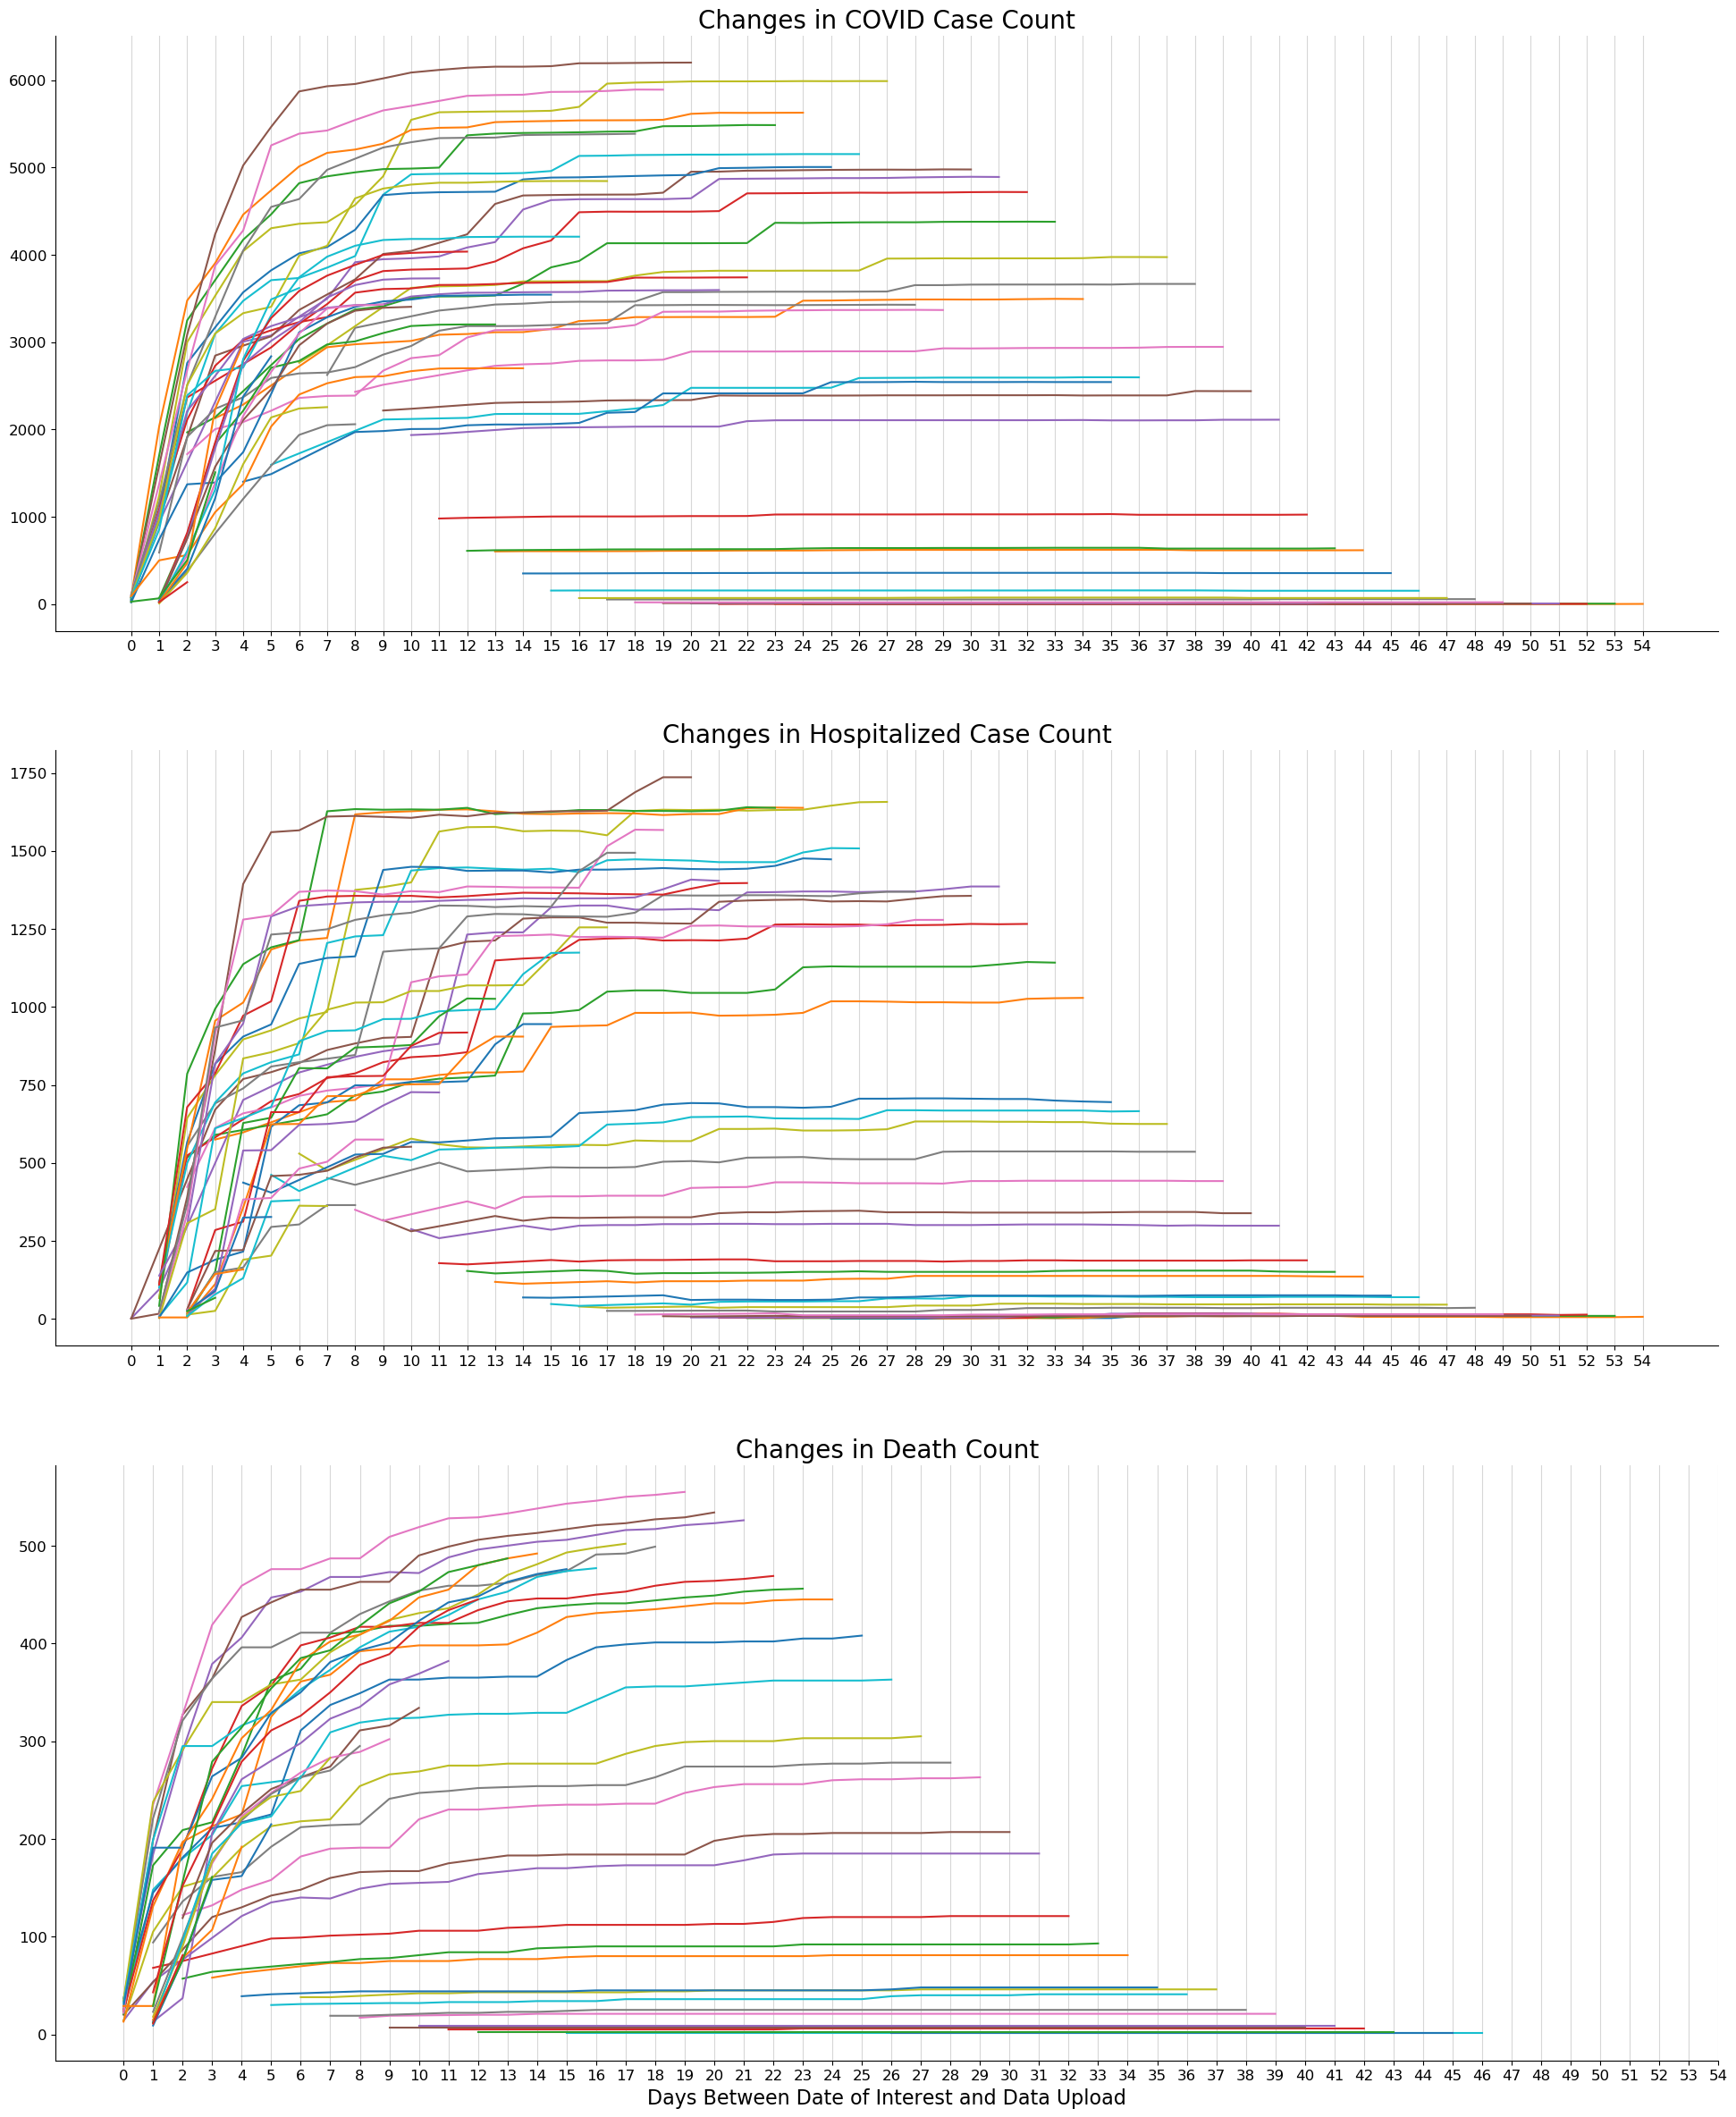

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(24,30), dpi=100)

for date in xtime.DATE_OF_INTEREST.unique():
    date_df = xtime[xtime.DATE_OF_INTEREST == date]
    days_passed = date_df['days_till_upload'].dt.days
    ax[0].plot(days_passed, date_df['NEW_COVID_CASE_COUNT'])
    ax[1].plot(days_passed, date_df['HOSPITALIZED_CASE_COUNT'])
    ax[2].plot(days_passed, date_df['DEATH_COUNT'])

labels = np.arange(xtime['days_till_upload'].dt.days.max()+1)
    
for i in range(3):
    ax[i].tick_params(labelsize=12)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xticks(labels)
    ax[i].grid(which='major', axis='x', alpha=0.5)
    
ax[0].set_title('Changes in COVID Case Count', fontsize=20)
ax[1].set_title('Changes in Hospitalized Case Count', fontsize=20)
ax[2].set_title('Changes in Death Count', fontsize=20)

ax[2].set_xlabel('Days Between Date of Interest and Data Upload', fontsize=16)

plt.show()

In [15]:
def percent_change(row, col):
    if row.days_till_upload == 0:
        return np.nan
    yesterday = row.days_till_upload - pd.Timedelta(days=1)
    mask = (xtime.DATE_OF_INTEREST==row.DATE_OF_INTEREST) \
                    & (xtime.days_till_upload==yesterday)
    if len(xtime[mask]) == 0:
        return np.nan
    old = xtime.loc[mask, col]
    new = row[col]
    change = ((new-old)/old)*100
    return change

xtime['percent_change_case'] = xtime.apply(percent_change, 
                                           args=(['NEW_COVID_CASE_COUNT']), 
                                           axis=1)

xtime['percent_change_hosp'] = xtime.apply(percent_change, 
                                           args=(['HOSPITALIZED_CASE_COUNT']), 
                                           axis=1)

xtime['percent_change_death'] = xtime.apply(percent_change, 
                                            args=(['DEATH_COUNT']), 
                                            axis=1)


In [16]:
def unarray(thing):
    return thing[0]


xtime['percent_change_case'] = xtime['percent_change_case'].map(unarray, na_action='ignore')
xtime['percent_change_hosp'] = xtime['percent_change_hosp'].map(unarray, na_action='ignore')
xtime['percent_change_death'] = xtime['percent_change_death'].map(unarray, na_action='ignore')

In [17]:
# most_recent_upload = xtime.upload_date.max()

def max_days(row):
    '''
    returns highest value of days_till_upload for given date of interest.
    does not assume latest possible upload date 
        (eg 3/2 excluded from uploads after 4/18
    '''
    return xtime[xtime.DATE_OF_INTEREST==row.DATE_OF_INTEREST].days_till_upload.max()

xtime['max_days'] =  xtime.apply(max_days, axis=1)

def max_value(row, col):
    '''
    returns value of column associated with most recent data upload 
       for given date of interest
    '''
    recent_mask = (xtime.DATE_OF_INTEREST==row.DATE_OF_INTEREST) \
                    & (xtime.days_till_upload == row.max_days)
    return xtime.loc[recent_mask, col].values

xtime['max_case'] =  xtime.apply(max_value, args=(['NEW_COVID_CASE_COUNT']), axis=1)
xtime['max_hosp'] =  xtime.apply(max_value, args=(['HOSPITALIZED_CASE_COUNT']), axis=1)
xtime['max_death'] =  xtime.apply(max_value, args=(['DEATH_COUNT']), axis=1)

xtime['max_case'] = xtime['max_case'].map(unarray, na_action='ignore')
xtime['max_hosp'] = xtime['max_hosp'].map(unarray, na_action='ignore')
xtime['max_death'] = xtime['max_death'].map(unarray, na_action='ignore')

xtime['max_case_change'] = xtime['NEW_COVID_CASE_COUNT']/xtime['max_case']
xtime['max_hosp_change'] = xtime['HOSPITALIZED_CASE_COUNT']/xtime['max_hosp']
xtime['max_death_change'] = xtime['DEATH_COUNT']/xtime['max_death']

In [18]:
from numpy import nanmean

# groupby days till upload
days_since_df = xtime.groupby('days_till_upload', as_index=False)\
                .agg({'percent_change_case':nanmean,
                      'percent_change_hosp':nanmean,
                      'percent_change_death':nanmean,
                      'max_case_change':nanmean,
                      'max_hosp_change':nanmean,
                      'max_death_change':nanmean})

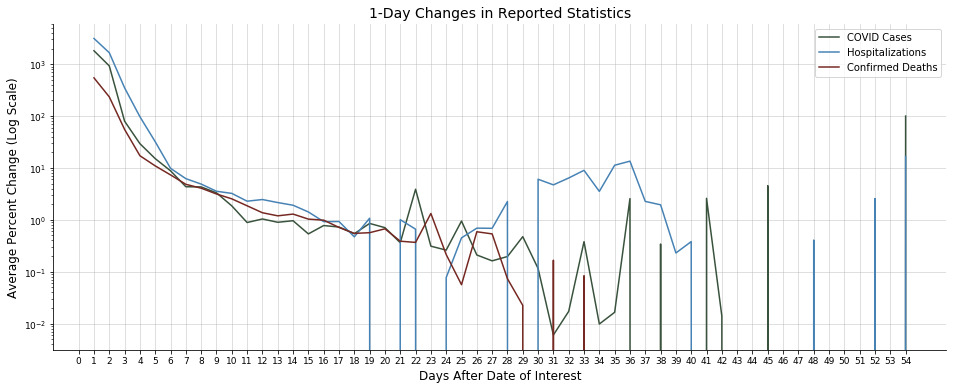

In [19]:
fig, ax = plt.subplots(figsize=(16,6))

xdays = days_since_df.days_till_upload.dt.days


ax.plot(xdays, days_since_df['percent_change_case'], lw=1.5, color='#39523c')
ax.plot(xdays, days_since_df['percent_change_hosp'], lw=1.5, color='steelblue')
ax.plot(xdays, days_since_df['percent_change_death'], lw=1.5, color='#752822')

ax.tick_params(labelsize=9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(labels)
ax.grid(which='major',alpha=0.5)
    
ax.set_title('1-Day Changes in Reported Statistics', fontsize=14)


ax.set_xlabel('Days After Date of Interest', fontsize=12)
ax.set_ylabel('Average Percent Change (Log Scale)', fontsize=12)
ax.set_yscale('log')
ax.legend(['COVID Cases', 'Hospitalizations', 'Confirmed Deaths'])


plt.show()

In [20]:
'''
Remove rows for which the most recent upload 
    is not at least 30 days after the date of interest.
    
This ensures that "max_value" returns a reliable figure.
'''

min_max_days = 30
xtime_clipped = xtime[xtime.max_days.dt.days>=min_max_days].copy()

# groupby days till upload
days_since_clipped = xtime_clipped.groupby('days_till_upload', 
                                           as_index=False).\
                        agg({'max_case_change':[nanmean,np.std], 
                             'max_hosp_change':[nanmean,np.std], 
                             'max_death_change':[nanmean,np.std]})

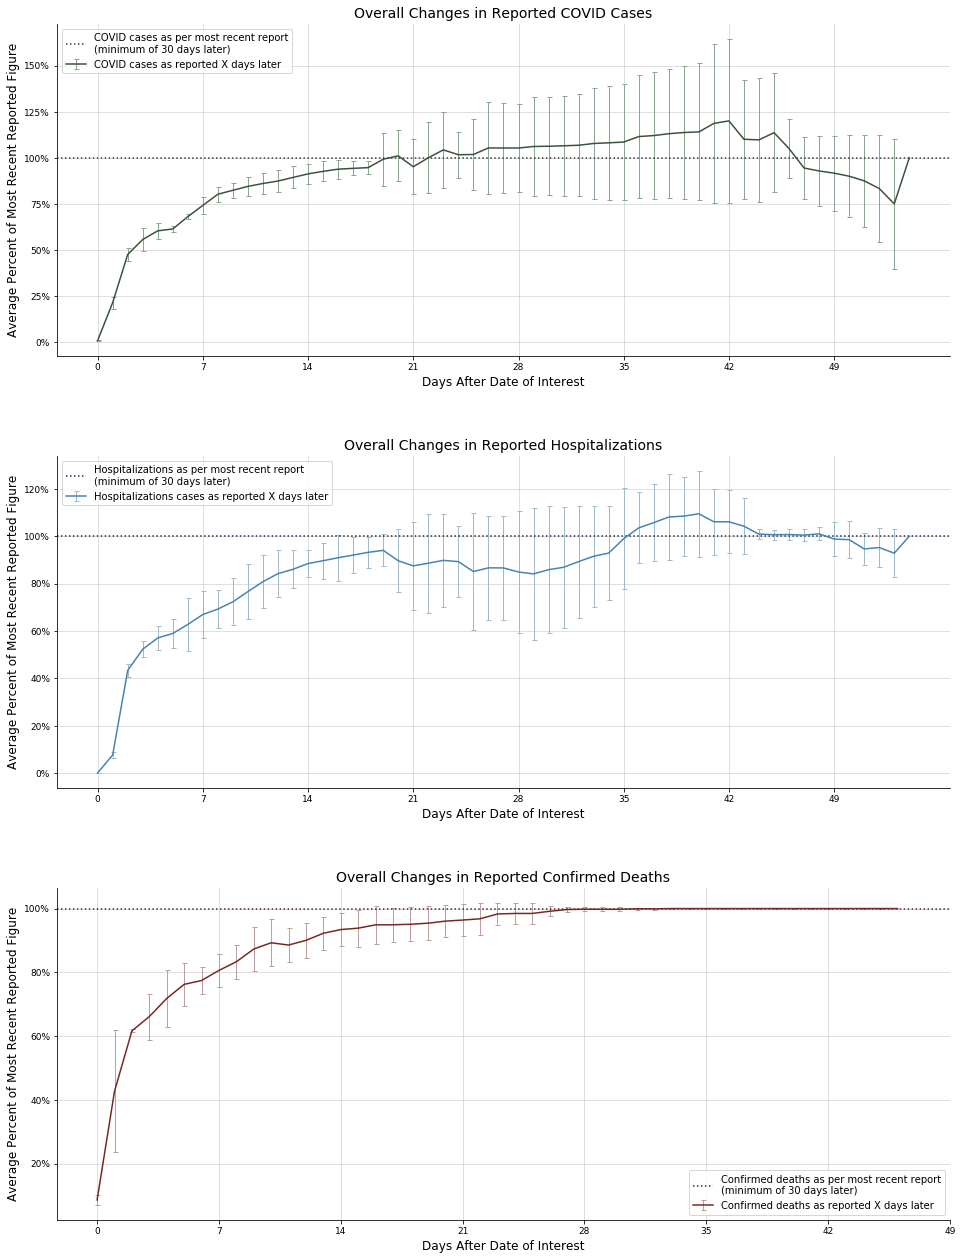

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(16,22))

xdays = days_since_clipped.days_till_upload.dt.days

ax[0].set_title('Overall Changes in Reported COVID Cases', fontsize=14)
ax[0].axhline(1, color='#313d34', linestyle='dotted')
ax[0].errorbar(xdays, days_since_clipped['max_case_change']['nanmean'], 
               color='#39523c', lw=1.5, 
               yerr=days_since_clipped['max_case_change']['std'], 
               capsize=2.5, ecolor='#88a690', elinewidth=1 )
ax[0].legend(['COVID cases as per most recent report\n(minimum of 30 days later)', 
              'COVID cases as reported X days later'])

ax[1].set_title('Overall Changes in Reported Hospitalizations', fontsize=14)
ax[1].errorbar(xdays, days_since_clipped['max_hosp_change']['nanmean'], 
               color='steelblue', lw=1.5, 
               yerr=days_since_clipped['max_hosp_change']['std'], 
               capsize=2.5, ecolor='#a1bbc9', elinewidth=1)
ax[1].axhline(1, color='#172c4f', linestyle='dotted')
ax[1].legend(['Hospitalizations as per most recent report\n(minimum of 30 days later)', 
              'Hospitalizations cases as reported X days later'])

ax[2].set_title('Overall Changes in Reported Confirmed Deaths', fontsize=14)
ax[2].errorbar(xdays, days_since_clipped['max_death_change']['nanmean'], 
               color='#752822', lw=1.5, 
               yerr=days_since_clipped['max_death_change']['std'], 
               capsize=2.5, ecolor='#bf9e9d', elinewidth=1)
ax[2].axhline(1, color='#472524', linestyle='dotted')
ax[2].legend(['Confirmed deaths as per most recent report\n(minimum of 30 days later)', 
              'Confirmed deaths as reported X days later'])


for i in range(3):
    ax[i].tick_params(labelsize=9)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xticks([x for x in labels if x%7==0])
    ax[i].set_yticklabels([str(int(100*x))+'%' for x in list(ax[i].get_yticks())])
    ax[i].grid(which='major',alpha=0.5)
    ax[i].set_ylabel('Average Percent of Most Recent Reported Figure', fontsize=12)
    ax[i].set_xlabel('Days After Date of Interest', fontsize=12)


plt.subplots_adjust(hspace=.3)  


plt.show()

In [22]:
# extract correction method from overall changes numbers?

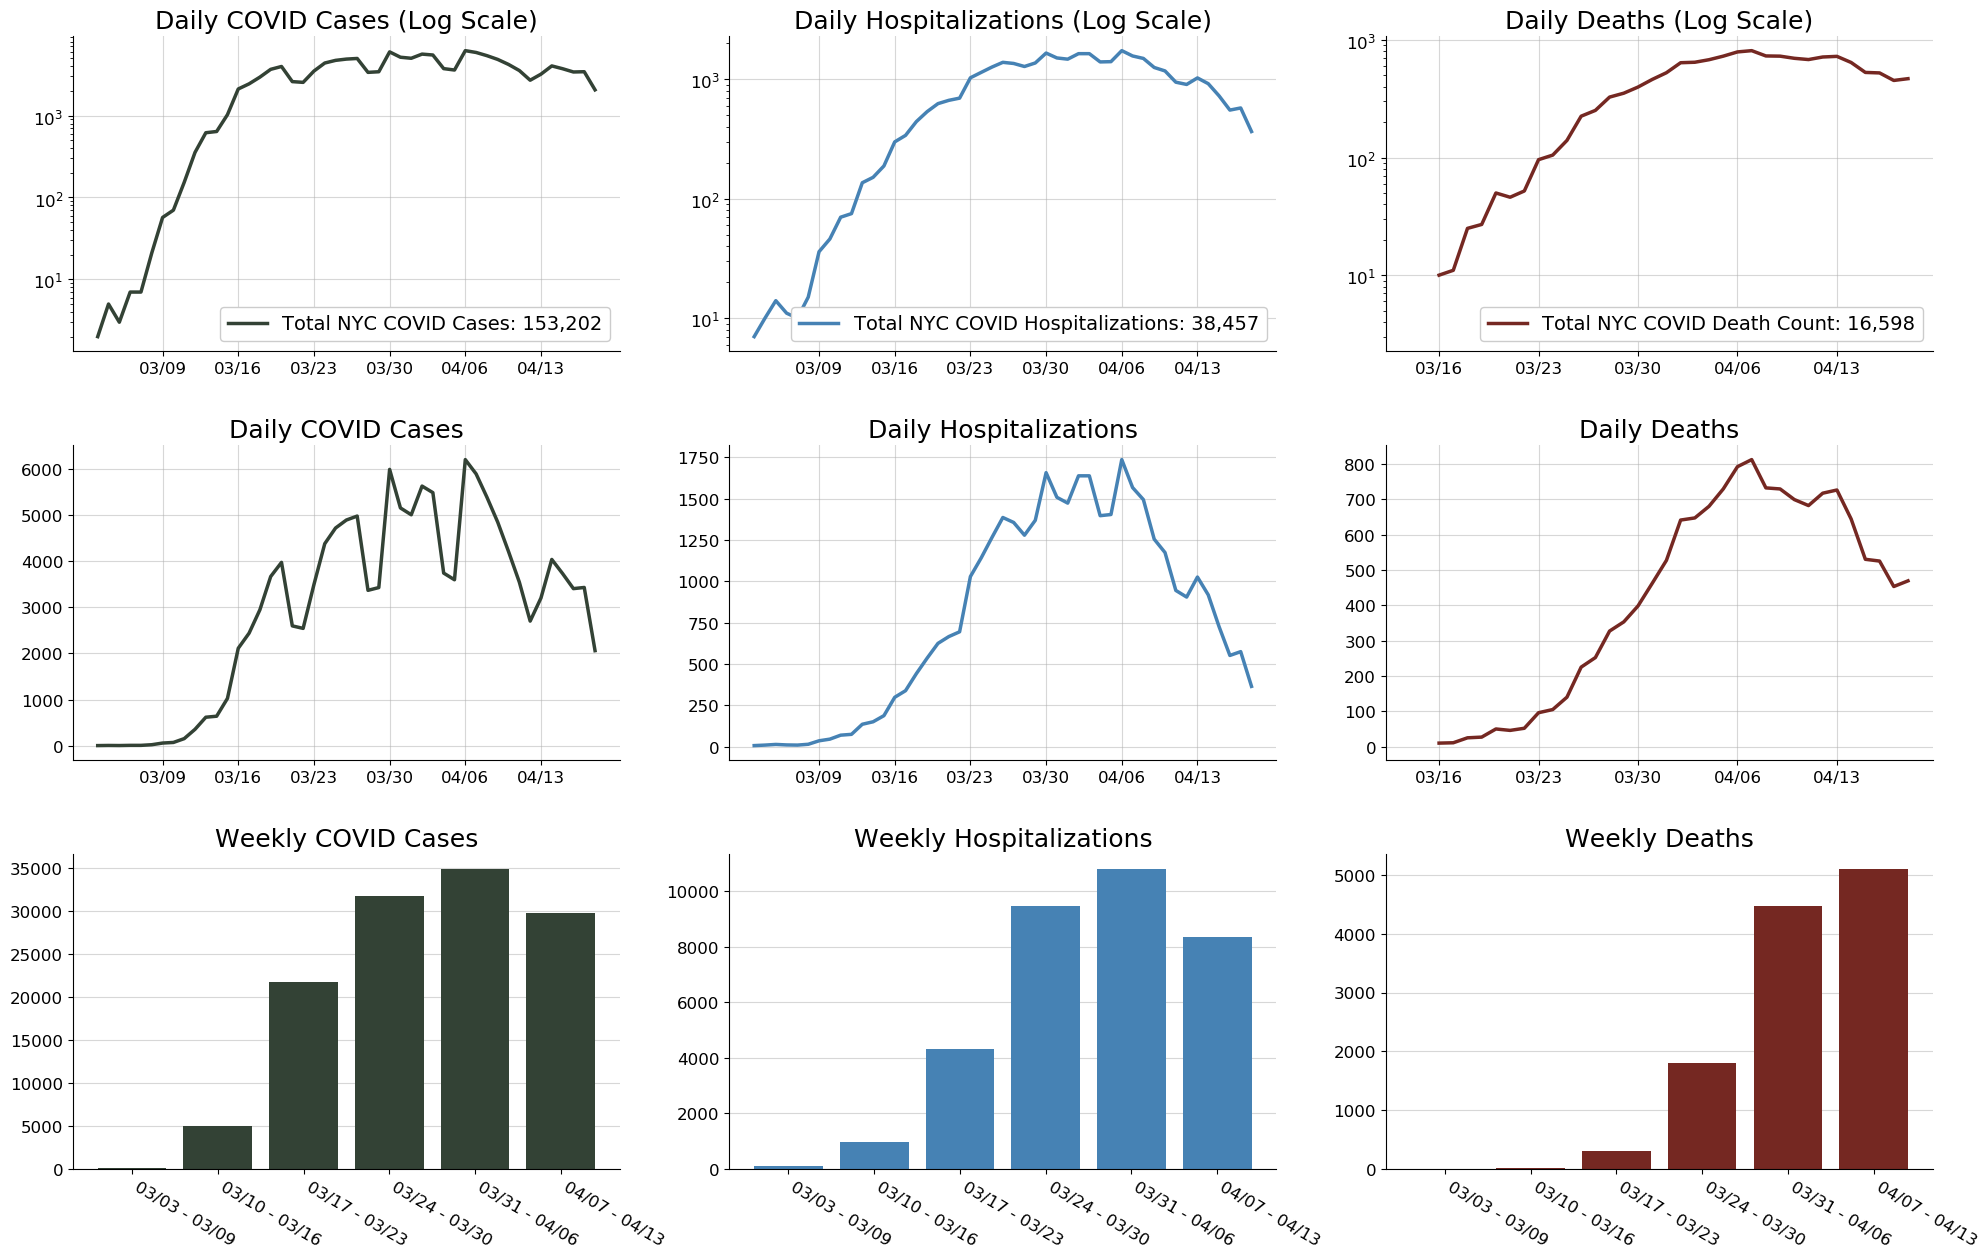

In [23]:
df_7 = run_dash_with_x_newest_days_removed(7)

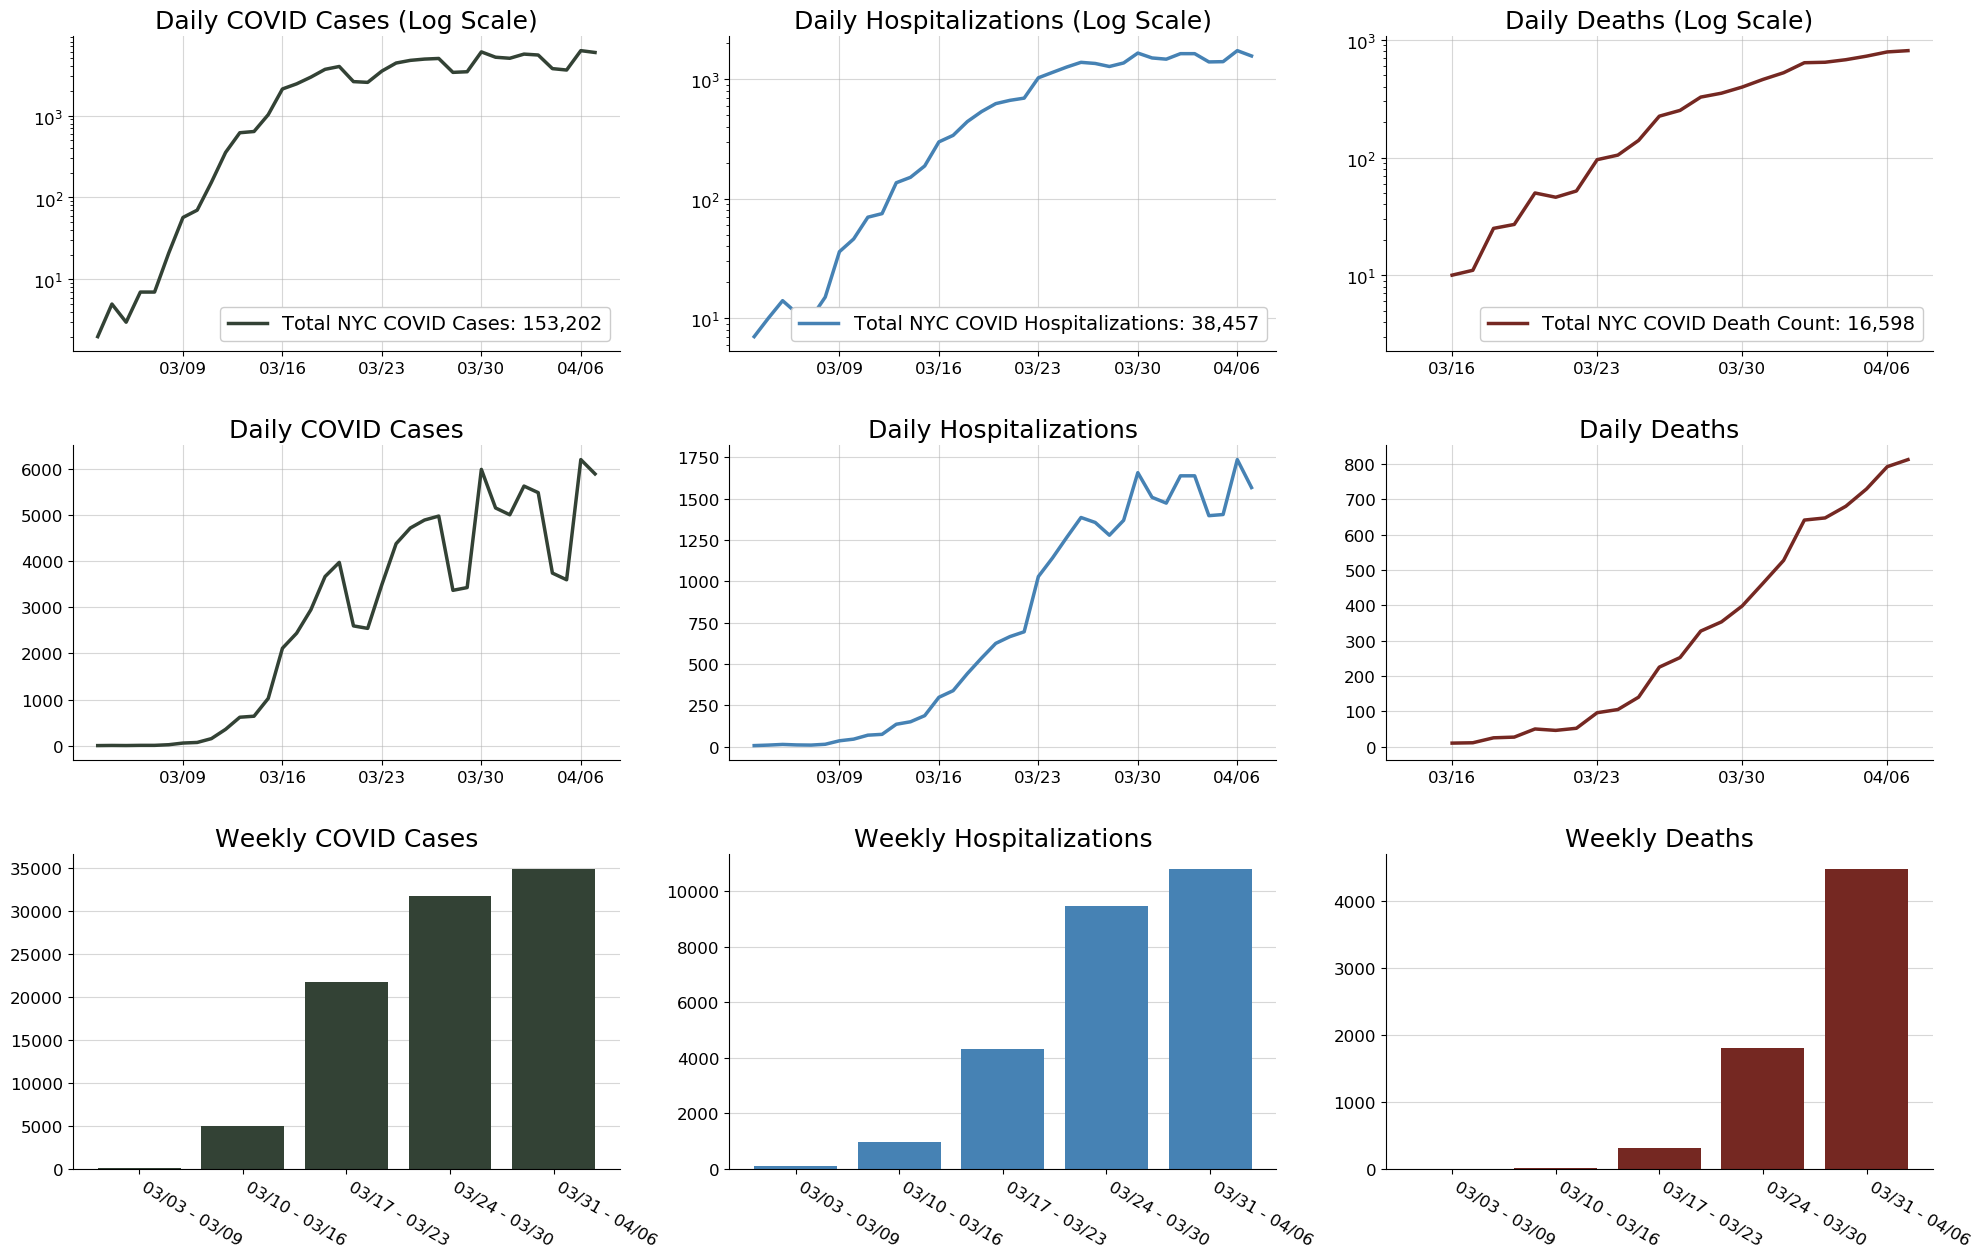

In [24]:
df_18 = run_dash_with_x_newest_days_removed(18)

## Breakdowns

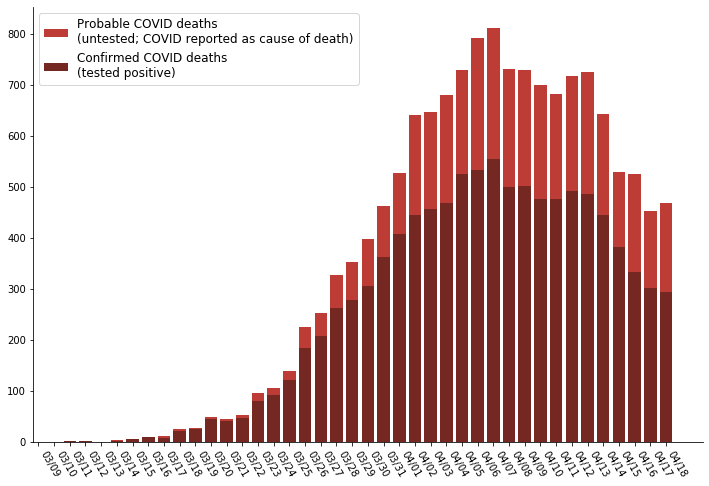

In [25]:
fig, ax = plt.subplots(figsize=(12,8))

# plot probable/confirmed death breakdown, excluding most recent 7 days
ax.bar(df_7['date'], df_7['deaths'], color='#bd3c35')
ax.bar(df_7['date'], df_7['CONFIRMED_DEATHS'], color='#752822')
ax.set_xticklabels(labels = df_7['date'], rotation=300, ha='left')
plt.legend(['Probable COVID deaths \n(untested; COVID reported as cause of death)', 
            'Confirmed COVID deaths \n(tested positive)'],
           loc='upper left', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [26]:
# display age breakdown table
age_df = pd.read_csv('by-age.csv')
age_df

,AGE_GROUP,COVID_CASE_RATE,HOSPITALIZED_CASE_RATE,DEATH_RATE
0,0-17 years,194.62,15.17,0.29
1,18-44 years,1675.94,166.54,14.01
2,45-64 years,2744.49,675.52,124.66
3,65-74 years,2746.03,1290.48,406.66
4,75 and older years,3188.99,1983.27,1019.24
5,Citywide total,1824.13,471.92,136.45


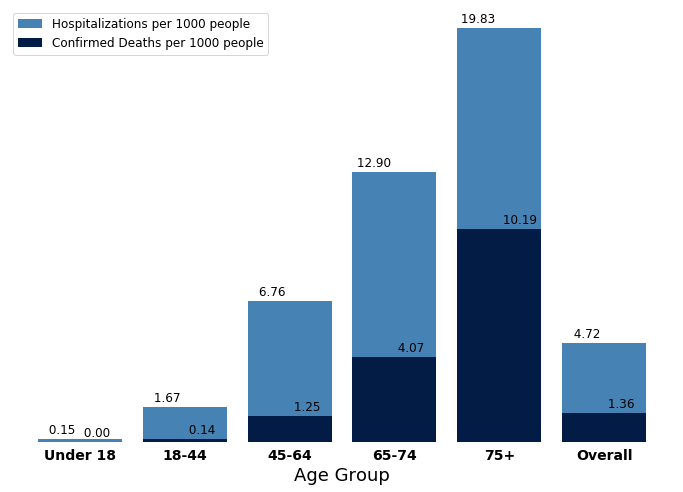

In [27]:
# plot age breakdown

fig, ax = plt.subplots(figsize=(12,8))


rects1 = ax.bar(age_df['AGE_GROUP'], age_df['HOSPITALIZED_CASE_RATE']/100, 
                color='steelblue')
rects2 = ax.bar(age_df['AGE_GROUP'], age_df['DEATH_RATE']/100, color='#021c45')
ax.set_xticklabels(labels = ['Under 18', '18-44', '45-64', '65-74', '75+', 'Overall'], 
                   ha='center', fontsize=14, fontweight='bold')
plt.legend(['Hospitalizations per 1000 people', 
            'Confirmed Deaths per 1000 people'],
          loc='upper left', fontsize=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

def autolabel(rects, pos):
    """
    Adapted from: https://matplotlib.org/gallery/api/barchart.html
    
    Attach a text label above each bar in *rects*, displaying its height.

    pos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*.5, height+.1,
                ' {:0.2f} '.format(height), ha=pos, va='bottom', fontsize=12)

autolabel(rects1, 'right')
autolabel(rects2, 'left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.yticks([], [])
ax.xaxis.set_ticks_position('none')
ax.set_xlabel('Age Group', fontsize=18)

plt.show()